In [28]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from scipy.stats import mstats
import statsmodels.api as sm

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [29]:
#Testing in the model on Florida Crimes
df = pd.read_csv("florida crimes.csv")

In [30]:
df = df.drop(['Rape\r(legacy\rdefinition)2'], axis=1)

In [31]:
df = df.rename(columns={'Violent\rcrime': 'Violent_Crime', 
                        'Murder and\rnonnegligent\rmanslaughter': 'Murder',
                       'Rape\r(revised\rdefinition)1' : 'Rape',
                       'Aggravated\rassault' : 'Aggravated_Assault',
                       'Property\rcrime': 'Property_Crime',
                       'Larceny-\rtheft': 'Larceny_Theft',
                       'Motor\rvehicle\rtheft': 'Motor_Vehicle_Theft',
                       'Arson3': 'Arson'})

In [32]:
df['Robbery'] = df['Robbery'].str.replace(',', '')
df['Larceny_Theft'] = df['Larceny_Theft'].str.replace(',', '')
df['Property_Crime'] = df['Property_Crime'].str.replace(',', '')
df['Burglary'] = df['Burglary'].str.replace(',', '')
df['Population'] = df['Population'].str.replace(',', '')
df['Poperty_Crime'] = df['Property_Crime'].str.replace(',', '')
df['Aggravated_Assault'] = df['Aggravated_Assault'].str.replace(',', '')

In [33]:
df['Property_Crime'] = pd.to_numeric(df['Property_Crime'])
df['Population'] = pd.to_numeric(df['Population'])
df['Aggravated_Assault'] = pd.to_numeric(df['Aggravated_Assault'])

In [34]:
df['Robbery'] = pd.to_numeric(df['Robbery'])
df['Robbery_Cat'] = np.where(df['Robbery']>0, 1, 0)
df['Arson']=df['Arson'].fillna(0)
df['Property_Crime']=df['Property_Crime'].fillna(0)

In [35]:
df['Murder'] = pd.to_numeric(df['Murder'])
df['Murder_Cat'] = np.where(df['Murder']>0, 1, 0)
print(df.head())

                City  Population Violent_Crime  Murder  Rape  Robbery  \
0            Alachua        9338            36       0     2        2   
1  Altamonte Springs       42040           150       0     8       37   
2              Altha         536             1       0     0        0   
3       Apalachicola        2269             1       0     0        0   
4             Apopka       45397           178       1    11       57   

   Aggravated_Assault  Property_Crime Burglary Larceny_Theft  \
0                  32         166.000       40           120   
1                 105        1564.000      300          1180   
2                   1           3.000        3             0   
3                   1          35.000        8            27   
4                 109        1527.000      231          1202   

  Motor_Vehicle_Theft  Arson Poperty_Crime  Robbery_Cat  Murder_Cat  
0                   6      1           166            1           0  
1                  84      3        

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11884add8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118838d68>]], dtype=object)

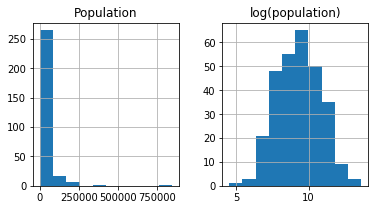

In [36]:
#Log the population variable 
plt.rcParams['figure.figsize'] = (6.0, 3.0)
population = pd.DataFrame({"Population":df["Population"], "log(population)":np.log(df["Population"])})
population.hist(bins = 10)

In [37]:
df['Population'] = np.log(df["Population"])

In [38]:
#If your data is suffering from nonlinearity, transform the dependent variables using sqrt, log, square, etc.
df['Population_Squared'] = df['Population']**2

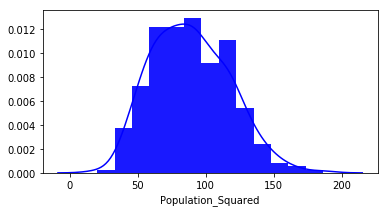

In [39]:
#Check if population squared is normally distributed.
sns.distplot(df['Population_Squared'], kde = True, color = 'b', hist_kws={'alpha': 0.9})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118844b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117b475c0>]], dtype=object)

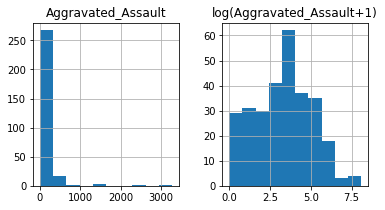

In [40]:
#Log the aggravated assault variable 
plt.rcParams['figure.figsize'] = (6.0, 3.0)
population = pd.DataFrame({"Aggravated_Assault":df["Aggravated_Assault"], 
                           "log(Aggravated_Assault+1)":np.log1p(df["Aggravated_Assault"])})
population.hist(bins = 10)

In [41]:
df['Aggravated_Assault'] = np.log1p(df["Aggravated_Assault"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117b9bd68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117c23978>]], dtype=object)

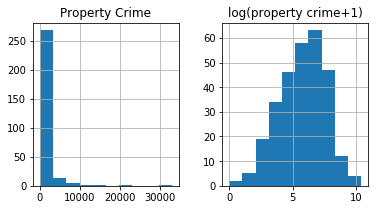

In [42]:
#Log the property crime variable 
plt.rcParams['figure.figsize'] = (6.0, 3.0)
population = pd.DataFrame({"Property Crime":df["Property_Crime"], "log(property crime+1)":np.log1p(df["Property_Crime"])})
population.hist(bins = 10)

In [43]:
df['Property_Crime'] = np.log1p(df["Property_Crime"])

In [44]:
linear_formula = 'Property_Crime ~ Population + Population_Squared + Aggravated_Assault + Murder_Cat + Robbery_Cat'
lm = smf.ols(formula=linear_formula, data=df).fit()
lm.params

Intercept            -4.140
Population            1.083
Population_Squared   -0.018
Aggravated_Assault    0.307
Murder_Cat            0.070
Robbery_Cat           0.395
dtype: float64

In [45]:
regr = linear_model.LinearRegression()
x = df[['Population', 'Population_Squared', 'Aggravated_Assault','Murder_Cat', 'Robbery_Cat']]
y = df['Property_Crime'].values.reshape(-1,1)
regr.fit(x,y)

#Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(x,y))


Coefficients: 
 [[ 1.08348315 -0.01754     0.30657766  0.07006359  0.39472295]]

Intercept: 
 [-4.14036293]

R-squared:
0.916186360982


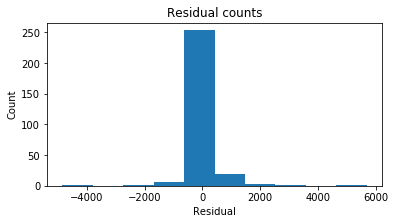

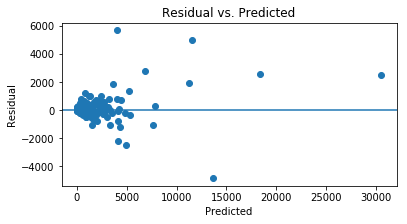

In [46]:
# Extract predicted values.
predicted = regr.predict(x).ravel()
predicted = np.expm1(predicted)
actual = df['Property_Crime']
actual = np.expm1(actual)

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [ ]:
#KNN model against OLS Mutiple Regression

In [72]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights = 'distance')
X = df[['Population', 'Population_Squared', 'Aggravated_Assault','Murder_Cat', 'Robbery_Cat']]
Y = df['Property_Crime'].values.reshape(-1,1)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')

In [79]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(232, 5) (232, 1)
(58, 5) (58, 1)


In [80]:
knn.fit(X_train, Y_train)

In [82]:
# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(X_test)

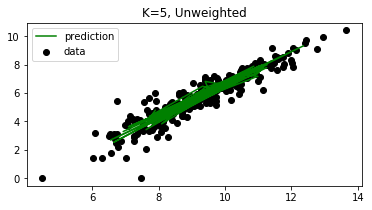

In [85]:
plt.scatter(X_train['Population'], Y_train, c='k', label='data')
plt.plot(X_test['Population'], Y_, c='g', label='prediction')
plt.legend()
plt.title('K=5, Unweighted')
plt.show()

In [88]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Weighted Accuracy: 0.86 (+/- 0.08)


In [ ]:
#OLS regression worked better for this example. 
#KNN is a non parametric method, while OLS linear regression is a parametric method. 
#Data assumes linear relationship between X and Y, hence the OLS regression worked better.
#KNN does not assume an explicit form for f(X), hence it is often more flexible.
